# DAgger (Dataset Aggregation)

In Behavioral Cloning (BC), we have seen the method to learn expert's behavior with a manner of solving regression/classification problems.

However, it sometimes happens that the learner encounters unknown states that the expert never encounters in her/his successful demonstrations. A small error at early time-step may then lead to further mistakes, leading to poor performance.<br>
DAgger addresses this problem by collecting the additional dataset of trajectories under the state distribution induced by the learned policy.

Unlike previous behavior cloning (BC) example, DAgger queries an expert **online** for demonstrations.<br>
This eventually reduces the size of training demonstrations to obtain satisfactory performance (compared to vanilla behavior cloning), but it's limited to the case in which the trainer can query an expert online (interactively) for demonstrations.

I note that DAgger essentially differs from the incremental learning, in which RL method follows to refine the trained policy. Unlike reinforcement learning (RL), DAgger doesn't also use the rewards to refine the policy.

> Note : However, you can progressively combine behavior cloning (BC), data aggregation (DAgger), and reinforcement learning (RL) for refinement to improve performance.<br>
> See [here](https://developer.nvidia.com/blog/training-sim-to-real-transferable-robotic-assembly-skills-over-diverse-geometries/) for real Robotics example in NVIDIA.

Now let's start.

*(back to [index](https://github.com/tsmatz/imitation-learning-tutorials/))*

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
get_ipython().system('pip install torch numpy')

In [ ]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-RL-Gym/Imitation-learning-Gridworld.git
! git pull origin master
# ! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 141 (delta 90), reused 76 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 1.45 MiB | 3.78 MiB/s, done.
Resolving deltas: 100% (90/90), done.
From https://github.com/tsmatz/imitation-learning-tutorials
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:


get_ipython().system('pip install torch numpy')



In [ ]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/tsmatz/imitation-learning-tutorials.git
! git pull origin master
# ! git pull origin main

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/tsmatz/imitation-learning-tutorials
 * branch            master     -> FETCH_HEAD
Already up to date.


Before we start, we need to install the required packages.

In [ ]:
!pip install torch numpy matplotlib

## Restore environment

Firstly, I restore GridWorld environment from JSON file.

For details about this environment, see [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md).

> Note : See [this script](./00_generate_expert_trajectories.ipynb) for generating the same environment.

In [ ]:
import torch
import json
from gridworld import GridWorld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("gridworld.json", "r") as f:
    json_object = json.load(f)
    env = GridWorld(**json_object, device=device)

Now I visualize our GridWorld environment.

The number in each cell indicates the reward score on this state.<br>
The goal state is on the right-bottom corner (in which the reward is ```10.0```), and the initial state is uniformly picked up from the gray-colored cells.<br>
If the agent can reach to goal state without losing any rewards, it will get ```10.0``` for total reward.

See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for details about the game rule of this environment.

In [ ]:
from IPython.display import HTML, display

valid_states_all = torch.cat((env.valid_states, torch.tensor([env.grid_size-1,env.grid_size-1]).to(device).unsqueeze(dim=0)))
valid_states_all = valid_states_all[:,0] * env.grid_size + valid_states_all[:,1]

html_text = "<table>"
for row in range(env.grid_size):
    html_text += "<tr>"
    for col in range(env.grid_size):
        if row*env.grid_size + col in valid_states_all:
            html_text += "<td bgcolor=\"gray\">"
        else:
            html_text += "<td>"
        html_text += str(env.reward_map[row*env.grid_size+col].tolist())
        html_text += "</td>"
    html_text += "</tr>"
html_text += "</table>"

display(HTML(html_text))

0,-1,0,0,0,-1,0,0,0,0,0,0,-1,0,-1,-1,-1,-1,0,-1,0,-1,0,0,0,-1,0,0,0,-1,-1,0,-1,0,0,0,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0
-1,0,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,-1,0,-1,0,-1,0,-1,0,-1,-1,0,0,0,-1,-1,0,0,-1,-1
0,0,-1,-1,0,-1,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,-1,0,0,0
0,0,-1,0,-1,-1,0,0,-1,0,-1,0,0,0,0,-1,0,-1,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,-1
-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,0,0
0,-1,-1,0,0,-1,0,-1,0,0,-1,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,-1,0,0,0,0,-1,-1,0,0,-1,0,-1,-1,-1,-1,0,0,-1,0,-1,0,0,0,0,0,-1
-1,-1,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,0,0,-1,-1,0,0,-1,-1,0,0,-1,-1,0,-1,0,0,0,0,0,0,0,-1,-1,0,0,0,-1,0,-1,0,-1,-1
0,0,0,0,-1,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,-1,0,0,-1,0,0,0,-1,-1,0,0,-1,0,-1,0,-1,0,0,-1,0,-1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,0,0,-1,0,0,-1,-1,0,0,0,0,0,0,-1,0,0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,0,-1,0,0,0,-1,0,0,0,0
0,0,0,-1,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,-1,0,-1,-1,-1
0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,-1,-1,0,-1,-1,0,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0


## Define policy

Now I build a policy $\pi$.

In DAgger, we need both expert policy and learner policy.<br>
The expert policy is already generated in [this script](./00_generate_expert_trajectories.ipynb) and the trained parameters are saved as ```expert_actor.pt``` in this repository.

This network receives the current state (one-hot state) as input and returns the optimal action (action's logits) as output.

In [ ]:
import torch.nn as nn
from torch.nn import functional as F

STATE_SIZE = env.grid_size*env.grid_size  # 2500
ACTION_SIZE = env.action_size             # 4

# Recover policy for expert
# (See 00_generate_expert_trajectories.ipynb.)
class ExpertNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.output = nn.Linear(STATE_SIZE, ACTION_SIZE, bias=False)

    def forward(self, state):
        logits = self.output(state)
        return logits

# Define policy for learner
class LearnerNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(STATE_SIZE, hidden_dim)
        self.classify = nn.Linear(hidden_dim, ACTION_SIZE)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

In [ ]:
# load expert model and freeze
expert_func = ExpertNet().to(device)
expert_func.load_state_dict(torch.load("expert_actor.pt"))
for param in expert_func.parameters():
    param.requires_grad = False

# load learner model
learner_func = LearnerNet().to(device)

## Run agent before training

For comparison, now I run this agent without any training.

In this game, the maximum episode's reward without losing any rewards is ```10.0```. (See [Readme.md](https://github.com/tsmatz/imitation-learning-tutorials/blob/master/Readme.md) for game rule in this environment.)<br>
As you can see below, it has low average of rewards.

In [ ]:
# Pick stochastic samples with policy model
def pick_sample(policy, s):
    """
    Stochastically pick up action and logits with policy model.

    Parameters
    ----------
    policy : torch.nn.Module
        Policy network to use
    s : torch.tensor((..., STATE_SIZE), dtype=int)
        The feature (one-hot) of state.
        The above "..." can have arbitrary shape with 0 or 1 dimension.

    Returns
    ----------
    action : torch.tensor((...), dtype=int)
        The picked-up actions.
        If input shape is (*, STATE_SIZE), this shape becomes (*).
    """
    # get logits from state
    # --> size : (*, ACTION_SIZE)
    logits = policy(s.float())
    # from logits to probabilities
    # --> size : (*, ACTION_SIZE)
    probs = F.softmax(logits, dim=-1)
    # pick up action's sample
    # --> size : (*, 1)
    a = torch.multinomial(probs, num_samples=1)
    # --> size : (*)
    a = a.squeeze()

    # Return
    return a

In [ ]:
def evaluate(policy, batch_size):
    total_reward = torch.tensor(0.0).to(device)
    s = env.reset(batch_size)
    while True:
        s_onehot = F.one_hot(s, num_classes=STATE_SIZE)
        with torch.no_grad():
            a = pick_sample(policy, s_onehot)
        s, r, term, trunc = env.step(a, s)
        total_reward += torch.sum(r)
        done = torch.logical_or(term, trunc)
        work_indices = (done==False).nonzero().squeeze(dim=-1)
        if not (len(work_indices) > 0):
            break;
        s = s[work_indices]
    return total_reward.item() / batch_size

avg_reward = evaluate(learner_func, 300)
print(f"Estimated rewards (before training): {avg_reward}")

Estimated rewards (before training): -67.64


## Train policy with DAgger

In DAgger, the following stochastic mixing $\pi_i$ (where $i$ is the number of training iteration) between expert policy $\pi^*$ and learner policy $\hat{\pi}_i$ is used to collect the visited states. (See [original paper](https://arxiv.org/pdf/1011.0686).)

$\pi_i = \beta_i \pi^* + (1 - \beta_i) \hat{\pi}_i$

where $\beta_i$ satisfies $\frac{1}{N} \sum_{i=1}^{N} \beta_i \to 0$.

In this example, I briefly set $\beta_i = p^{i - 1}$ where $0 \lt p \lt 1$.

In [ ]:
def get_beta(p, iter_num):
    return p**iter_num

Now I create a function to collect the visited states by applying the stochastic mixing with $\beta_i$.

> Note : You can run as a batch to speed up training. (Here I run each inference one by one.)

In [ ]:
import random

def collect_states(expert, learner, p_for_beta, i, collect_dat):
    """
    Collect visited states with mixing policies on i-th iteration

    Parameters
    ----------
    expert : torch.nn.Module
        Online expert policy.
    learner : torch.nn.Module
        Learner policy.
    p_for_beta : int
        Base p value used in get_beta() function.
    i : int
        The number of training iteration
        (which is passed as iter_num in get_beta() function)
    collect_dat : int
        The number of data to collect.

    Returns
    ----------
    states : tensor of int[collect_dat, STATE_SIZE]
        Collected onehot states. (The number of row is collect_dat.)
    """

    collected_states = []
    beta  = get_beta(p_for_beta, i)
    done = True
    while len(collected_states) < collect_dat:
        if done:
            s = env.reset(batch_size=1)
            done = False
        s_onehot = F.one_hot(s.squeeze(dim=0), num_classes=STATE_SIZE)
        collected_states.append(s_onehot)
        rnd = random.uniform(0, 1)
        policy = expert if rnd < beta else learner
        with torch.no_grad():
            a = pick_sample(policy, s_onehot)
        s, _, term, trunc = env.step(a.unsqueeze(dim=0), s)
        done = torch.logical_or(term, trunc).squeeze(dim=0)
    return torch.stack(collected_states, dim=0)

Now we start training with DAgger.

> Note : To simplify, here I store all history in memory, but in practice, please save on disk to prevent the failure of memory allocation.

In [ ]:
#
# Define train() function
#
def train(expert, learner, p_for_beta, collect_dat, total_aggregate, train_batch_size, verbose=False):
    """
    Train with DAgger.

    Parameters
    ----------
    expert : torch.nn.Module
        Online expert policy.
    learner : torch.nn.Module
        Learner policy.
    p_for_beta : int
        Base p value used in get_beta() function.
    collect_dat : int
        The number of data to collect in each data aggregation.
    total_aggregate : int
        The number of aggregation.
        As a result, the number of total collected data will be collect_dat * total_aggregate.
    train_batch_size : int
        The number of data in each training batch.
        The collected data is divided into this chunk as a batch, and each batch is then trained.
    verbose : bool
        Whether to print results or not

    Returns
    ----------
    logs : int[total_aggregate]
        Returns the results of evaluated rewards in each aggregation.
    """

    reward_log = []
    visited_states_all = torch.empty((0,STATE_SIZE), dtype=torch.int64).to(device)
    expert_actions_all = torch.empty((0), dtype=torch.int64).to(device)

    # create optimizer
    opt = torch.optim.AdamW(learner.parameters(), lr=0.001)

    for i in range(total_aggregate):
        # collect visited states (onehot)
        visited_states = collect_states(expert, learner, p_for_beta, i, collect_dat)
        # collect expert actions
        with torch.no_grad():
            logits = expert(visited_states.float())
        probs = F.softmax(logits, dim=-1)
        expert_actions = torch.multinomial(probs, num_samples=1)
        expert_actions = expert_actions.squeeze(dim=-1)
        # combine dataset
        visited_states_all = torch.cat((visited_states_all, visited_states), dim=0)
        expert_actions_all = torch.cat((expert_actions_all, expert_actions), dim=0)
        # shuffle dataset for training
        indices = torch.randperm(visited_states_all.shape[0])
        visited_states_train = visited_states_all[indices]
        expert_actions_train = expert_actions_all[indices]
        # train leraner policy by chunking dataset
        for j in range(0, collect_dat, train_batch_size):
            opt.zero_grad()
            logits = learner(visited_states_train[j:j+train_batch_size].float())
            loss = F.cross_entropy(logits, expert_actions_train[j:j+train_batch_size], reduction="none")
            loss.sum().backward()
            opt.step()
        # evaluate policy and log
        avg = evaluate(learner, 200)
        reward_log.append(avg)
        if verbose:
            print("Iteration {:2d} - Evaluation result (Average reward) {}".format(i + 1, avg))

    # return evaluation reward's log
    return reward_log

#
# Run training
#
dagger_results = train(
    expert=expert_func,
    learner=learner_func,
    p_for_beta=0.3,
    collect_dat=5000,
    total_aggregate=30,
    train_batch_size=200,
    verbose=True,
)

Iteration  1 - Evaluation result (Average reward) -65.745
Iteration  2 - Evaluation result (Average reward) -64.375
Iteration  3 - Evaluation result (Average reward) -55.17
Iteration  4 - Evaluation result (Average reward) -47.39
Iteration  5 - Evaluation result (Average reward) -39.03
Iteration  6 - Evaluation result (Average reward) -33.85
Iteration  7 - Evaluation result (Average reward) -23.025
Iteration  8 - Evaluation result (Average reward) -13.82
Iteration  9 - Evaluation result (Average reward) -8.915
Iteration 10 - Evaluation result (Average reward) -3.25
Iteration 11 - Evaluation result (Average reward) -0.79
Iteration 12 - Evaluation result (Average reward) 1.595
Iteration 13 - Evaluation result (Average reward) 4.65
Iteration 14 - Evaluation result (Average reward) 4.795
Iteration 15 - Evaluation result (Average reward) 5.495
Iteration 16 - Evaluation result (Average reward) 6.525
Iteration 17 - Evaluation result (Average reward) 7.05
Iteration 18 - Evaluation result (Aver

## Compare results with BC

Now let's compare with the results of vanilla BC (behavior cloning).

> Note : In below code, I have trained with BC by setting ```p_for_beta=1.0```.

As you can easily see, DAgger has better performance (converge faster) than the results of vanilla BC.

This example uses a primitive environment (GridWorld) to learn policy, but the real system is more complex and the learner often encounters the unseen states (especillay, in early stages) that the expert never encounters in successful demonstrations. As a result, the learner never converges or very slowly converges into optimal performance in vanilla BC methods.<br>
In such case, there might be a clear difference between the results of two methods.

DAgger addresses this problem by applying optimization with the visited states induced also by learner policy (not only expert policy).

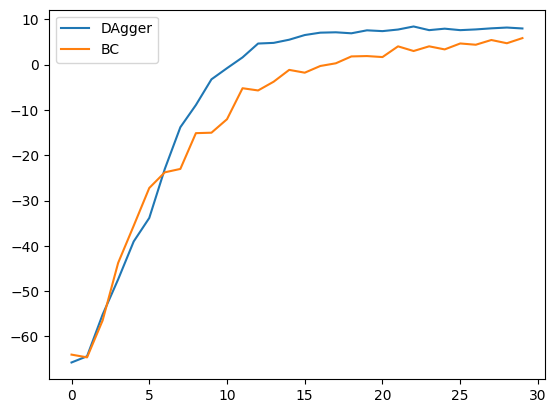

In [ ]:
import matplotlib.pyplot as plt

# train with behavior cloning (BC)
# (by setting p_for_beta=1.0)
bc_learner_func = LearnerNet().to(device)
bc_results = train(
    expert=expert_func,
    learner=bc_learner_func,
    p_for_beta=1.0,
    collect_dat=5000,
    total_aggregate=30,
    train_batch_size=200,
)

# plot
plt.plot(dagger_results, label="DAgger")
plt.plot(bc_results, label="BC")
plt.legend()
plt.show()

In [ ]:
bc_results

[-64.01,
 -64.615,
 -56.475,
 -43.755,
 -35.565,
 -27.235,
 -23.775,
 -23.025,
 -15.13,
 -15.03,
 -12.055,
 -5.215,
 -5.705,
 -3.775,
 -1.165,
 -1.785,
 -0.305,
 0.29,
 1.805,
 1.885,
 1.665,
 4.03,
 3.0,
 4.035,
 3.355,
 4.665,
 4.385,
 5.43,
 4.715,
 5.85]